<a href="https://colab.research.google.com/github/karthikmnkrishna/Loan-default-prediction/blob/Build/Loan_Case_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LOAN CASE STUDY

##DATA & LIBRARIES IMPORT

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/Masters/loan.csv'
df = pd.read_csv(path)
print(df.shape)

(39717, 111)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## DATA CLEANING AND FORMATING

###Checking if there is any incosistency in column names

In [4]:
df.columns.values

array(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint

The column names have no formating issue

Checking for columns that have only a single value,and hence may not be considered for analysis

In [5]:
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,34.000000,90.000000,9.000000,0.0000

In [6]:
df.groupby(['acc_now_delinq','application_type','collections_12_mths_ex_med','initial_list_status','policy_code','pymnt_plan','chargeoff_within_12_mths','delinq_amnt','tax_liens']).count()['id']

acc_now_delinq  application_type  collections_12_mths_ex_med  initial_list_status  policy_code  pymnt_plan  chargeoff_within_12_mths  delinq_amnt  tax_liens
0               INDIVIDUAL        0.0                         f                    1            n           0.0                       0            0.0          39661
Name: id, dtype: int64

In [0]:
df.drop(['acc_now_delinq','collections_12_mths_ex_med','initial_list_status','policy_code','application_type','pymnt_plan','chargeoff_within_12_mths','delinq_amnt','tax_liens','url'] ,axis = 1,inplace= True) #REMOVING URL, AS IT SEEMS TO BE A REPITION OF ID COLUMN 

Setting index as id . it seems to be the primary keys as it has all unique values and the description vouches our assumption

In [0]:
df.set_index('id',inplace =True)

###Checking Rows for redundancy/inconsistency

In [9]:
pd.set_option("max_colwidth", None)
df.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,...,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up.<br><br> Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces<br>,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.<br>",other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1075358,1311748,3000,3000,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay towa

Both the header and footer look fine.There are no extra rows.

###TREATING MISSING VALUES

Lets oserve all the columns with non null and null values and get rid of the columns with only null

In [10]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39717 entries, 1077501 to 87023
Data columns (total 100 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   member_id                       39717 non-null  int64  
 1   loan_amnt                       39717 non-null  int64  
 2   funded_amnt                     39717 non-null  int64  
 3   funded_amnt_inv                 39717 non-null  float64
 4   term                            39717 non-null  object 
 5   int_rate                        39717 non-null  object 
 6   installment                     39717 non-null  float64
 7   grade                           39717 non-null  object 
 8   sub_grade                       39717 non-null  object 
 9   emp_title                       37258 non-null  object 
 10  emp_length                      38642 non-null  object 
 11  home_ownership                  39717 non-null  object 
 12  annual_inc               

COLUMNS WITH ONLY NULL VALUES HAVE BEEN REMOVED.<br>
COLUMNS WITH TOO MANY NULL VALUES HAVE BEEN REMOVED (next_pymnt_d)<br>
ROWS WITH MINIMUM NULL VALUES  HAVE BEEN IGNORED IN SOME CASES<br>

In [0]:
df.drop([ 'annual_inc_joint', 'dti_joint','mths_since_last_major_derog',
 'verification_status_joint','tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths',
 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75',   'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd','tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit','next_pymnt_d','mths_since_last_record'  ],axis =1,inplace = True)

In [0]:
df = df[~df.title.isna()]
df = df[~df.pub_rec_bankruptcies.isna()]
df = df[~df.last_pymnt_d.isna()]
df = df[~df.last_credit_pull_d.isna()] 

Cleaning Columns and Rows - after removing the null values <br>CLEANING DESC COLUMN AND FORMATING INTEREST RATE ,ZIP CODE ,Term and other date columns<br>
I'm surious to know if  emp_title or emp_length will give any thing interesting when it is not given.

In [0]:
df.desc.fillna(' ' ,inplace= True)
df.revol_util.fillna(-1 ,inplace= True)#reomve if not useful
df.mths_since_last_delinq.fillna(-1 ,inplace= True)#reomve if not useful
df.emp_title.fillna('Not Given' ,inplace= True)#reomve if not useful
df.emp_length.fillna('Not Given' ,inplace= True)#reomve if not useful
df['desc'] = df.desc.str.replace('<br>' , '')
df['desc'] =df.desc.str.replace('Borrower added on ' , '')
df['desc'] = df.desc.str.replace('(1[0-2]|0[1-9])/(3[01]|[12][0-9]|0[1-9])/(1[0-2]|0[1-9])' , '')
df['desc'] =df.desc.str.replace('>' ,'')

In [0]:
df['int_rate'] = df.int_rate.apply(lambda x : float(x.strip('%'))/100 )
df['revol_util'] = df.revol_util.apply(lambda x : float(x.strip('%'))/100 if (x != -1 ) else -1) # -1 so that we can regonize the columns and ignore if necessary

In [0]:
df['zip_code'] = df.zip_code.str.replace('xx' ,'')

In [0]:
df['term']= df.term.str.strip()

In [0]:
df['last_credit_pull_d'] =df.last_credit_pull_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['issue_d'] =df.issue_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['earliest_cr_line'] =df.earliest_cr_line.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )
df['last_pymnt_d'] =df.last_pymnt_d.apply(lambda x : datetime.datetime.strptime(x, '%b-%y') if pd.isnull(x) == False else  datetime.date(9999, 12,31) )

In [18]:
df.isna().sum()

member_id                  0
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
desc                       0
purpose                    0
title                      0
zip_code                   0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
mths_since_last_delinq     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_in

###CHECKING FOR OUTLIERS

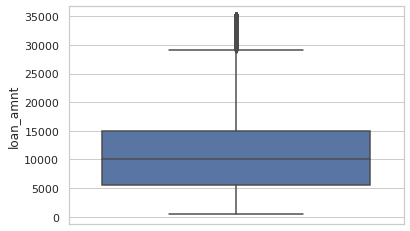

In [19]:
sns.set(style="whitegrid")
sns.boxplot(y=df.loan_amnt)

In [20]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies
count,3.893700e+04,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,3.893700e+04,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000,38937.000000
mean,8.620738e+05,11247.970439,10973.287618,10548.512595,0.120418,324.756877,6.900425e+04,13.362382,0.145363,0.865732,12.030074,9.296428,0.055449,13392.270180,0.487790,22.152272,52.254103,52.011213,12211.472950,11750.108575,9834.079083,2281.970220,1.328033,94.095695,12.102286,2704.282732,0.043198
std,2.534601e+05,7471.739408,7199.326345,7104.374465,0.037430,208.820843,6.320403e+04,6.669048,0.489809,1.066685,21.990996,4.382289,0.237989,15848.581819,0.287468,11.395272,378.841331,377.479914,9067.533732,8929.109967,7078.255720,2625.009916,7.139203,684.381010,146.925319,4467.082745,0.204188
min,8.036400e+04,500.000000,500.000000,0.000000,0.054200,16.080000,4.000000e+03,0.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,-1.000000,2.000000,0.000000,0.000000,33.730000,0.000000,0.000000,6.220000,0.000000,0.000000,0.000000,0.010000,0.000000
25%,6.758090e+05,5500.000000,5400.000000,5000.000000,0.092500,167.340000,4.080000e+04,8.240000,0.000000,0.000000,-1.000000,6.000000,0.000000,3728.000000,0.255000,14.000000,0.000000,0.000000,5598.284713,5315.780000,4650.000000,666.730000,0.000000,0.000000,0.000000,221.190000,0.000000
50%,8.582830e+05,10000.000000,9700.000000,9000.000000,0.118600,280.390000,5.900400e+04,13.450000,0.000000,1.000000,-1.000000,9.000000,0.000000,8873.000000,0.494000,20.000000,0.000000,0.000000,9958.640000,9489.360000,8000.000000,1356.740000,0.000000,0.000000,0.000000,554.050000,0.000000
75%,1.050176e+06,15000.000000,15000.000000,14497.884390,0.146100,430.780000,8.250000e+04,18.630000,0.000000,1.000000,21.000000,12.000000,0.000000,17080.000000,0.724000,29.000000,0.000000,0.000000,16605.880000,16000.610000,13800.000000,2861.030000,0.000000,0.000000,0.000000,3344.420000,0.000000
max,1.314167e+06,35000.000000,35000.000000,35000.000000,0.245900,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,120.000000,44.000000,4.000000,149588.000000,0.999000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,36115.200000,2.000000


DIGGING DEEPER ON ANNUAL INCOME
<BR>--out_prncp	out_prncp_inv<br>	total_pymnt	total_pymnt_inv	total_rec_prncp	total_rec_int,revol_bal

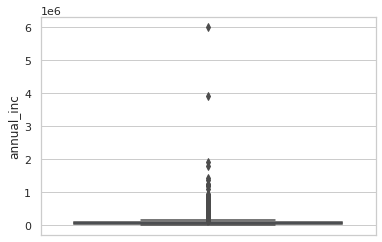

In [21]:
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc)

In [22]:
df.total_pymnt.quantile([0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99,1],)

0.000       33.730000
0.001      199.399520
0.010      854.751600
0.025     1290.786000
0.050     1939.690056
0.100     3005.160716
0.250     5598.284713
0.500     9958.640000
0.750    16605.880000
0.975    35624.909462
0.990    42341.333333
1.000    58563.679930
Name: total_pymnt, dtype: float64

In [23]:
df.annual_inc.quantile([0,0.001,0.01,.025,.05,.1, .25, .5, .75,.975 ,.99 ,1],)

0.000       4000.000
0.001       8498.208
0.010      14400.000
0.025      19200.000
0.050      24000.000
0.100      30000.000
0.250      40800.000
0.500      59004.000
0.750      82500.000
0.975     175000.000
0.990     234853.440
1.000    6000000.000
Name: annual_inc, dtype: float64

In [0]:
df = df[df.annual_inc.between(df.annual_inc.quantile(0), df.annual_inc.quantile(.99))]

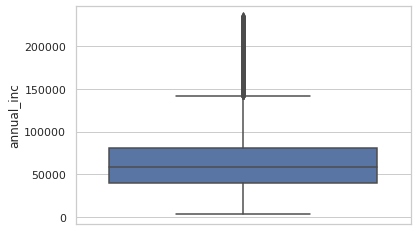

In [25]:
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc)



##UNIVARIATE ANALYSIS


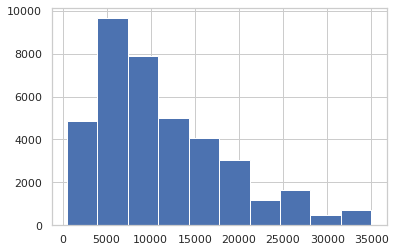

In [26]:
df.loan_amnt.hist()

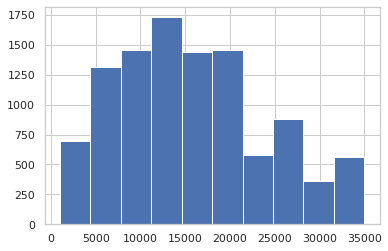

In [27]:
df[df.term == '60 months'].loan_amnt.hist()

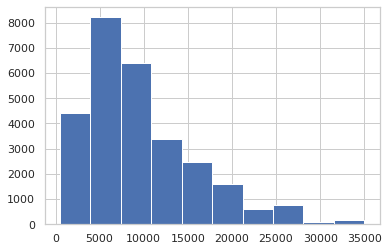

In [28]:
df[df.term == '36 months'].loan_amnt.hist()

In [29]:
pd.crosstab(index=  [df.verification_status],columns = df.loan_status, values= df.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status,Charged Off,Current,Fully Paid
verification_status,,,
Not Verified,0.122663,0.014099,0.863238
Source Verified,0.143017,0.031082,0.825901
Verified,0.159591,0.047060,0.793350


Checking impact  of loan amount 

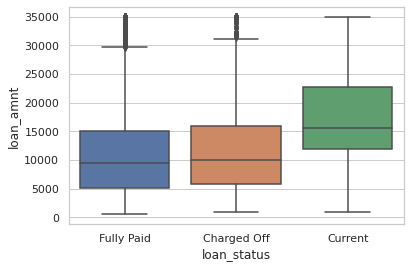

In [30]:
sns.set(style="whitegrid")
sns.boxplot(y=df.loan_amnt , x= df.loan_status)

Loan amount doesnt seem to have major impact on status , although loan amount is more varied in case of charged off loans.

LETS OBSERVE IMPACT OF ANNUAL INCOME ON LOAN STATUS

In [31]:
df.annual_inc.describe()

count     38547.000000
mean      65609.736975
std       35171.339826
min        4000.000000
25%       40200.000000
50%       58260.000000
75%       81000.000000
max      234600.000000
Name: annual_inc, dtype: float64

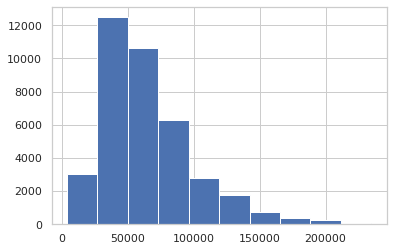

In [32]:
df.annual_inc.hist()

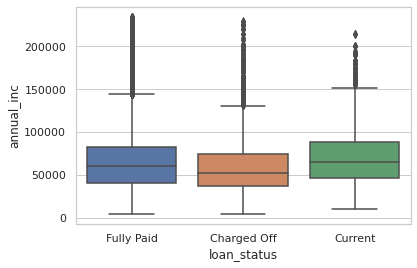

In [33]:
sns.set(style="whitegrid")
sns.boxplot(y=df.annual_inc , x= df.loan_status)

the annual income seems to be on the lower side in case of charged off loans

CHECKING THE IMPACT OF dti on LOAN STATUS

In [34]:
df.dti.describe()

count    38547.000000
mean        13.423189
std          6.654058
min          0.000000
25%          8.330000
50%         13.510000
75%         18.680000
max         29.990000
Name: dti, dtype: float64

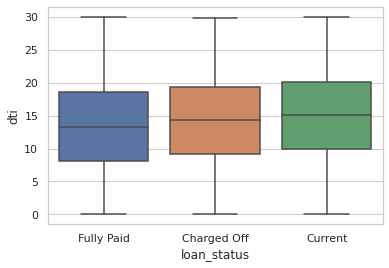

In [35]:
sns.set(style="whitegrid")
sns.boxplot(y=df.dti , x= df.loan_status) 

CHECKING THE IMPACT OF LAST 6 MONTHS ENQUIRY on LOAN STATUS

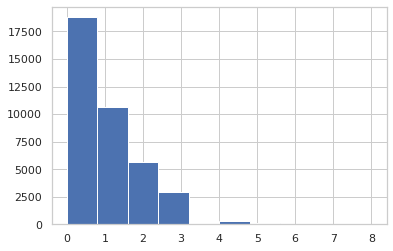

In [36]:
df.inq_last_6mths.hist()

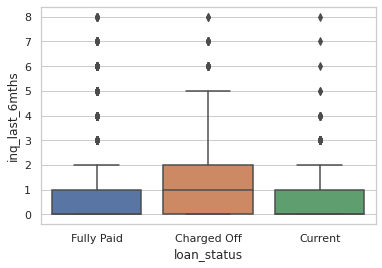

In [37]:
sns.set(style="whitegrid")
sns.boxplot(y=df.inq_last_6mths , x= df.loan_status) 

chances of loan being charged off seems to increase with increase in enquiries

checking impact of interest rate

In [38]:
df.int_rate.describe()

count    38547.000000
mean         0.120263
std          0.037355
min          0.054200
25%          0.090700
50%          0.118600
75%          0.145900
max          0.245900
Name: int_rate, dtype: float64

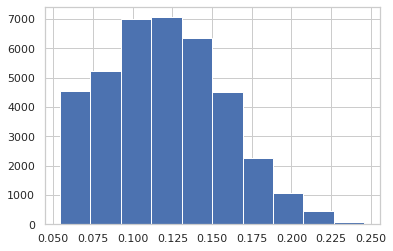

In [39]:
df.int_rate.hist()

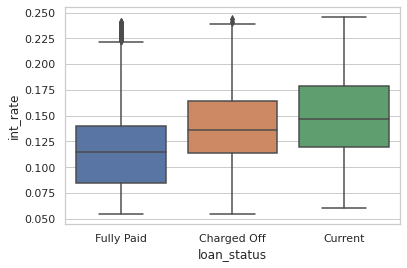

In [40]:
sns.set(style="whitegrid")
sns.boxplot(y=df.int_rate , x= df.loan_status) 

Increase in intrest rate  increases the chances of loan being charged off

checking impact of utilization rate

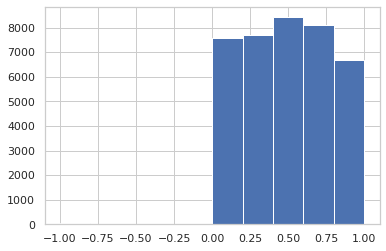

In [41]:
df.revol_util.hist()

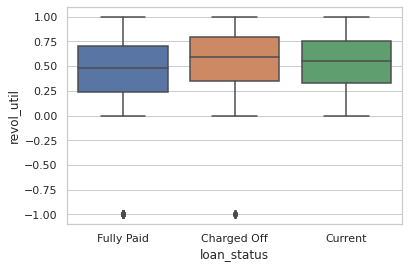

In [42]:
sns.set(style="whitegrid")
sns.boxplot(y=df.revol_util , x= df.loan_status) 

Increase in utilization of revolving line  increases the chances of loan being charged off

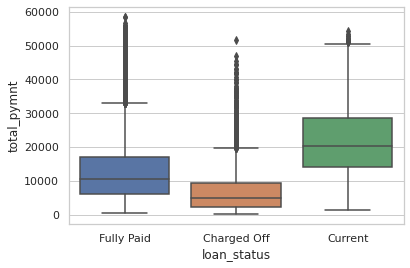

In [43]:
sns.set(style="whitegrid")
sns.boxplot(y=df.total_pymnt , x= df.loan_status) 

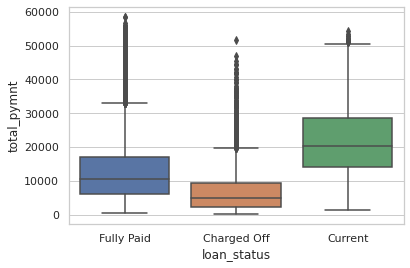

In [44]:
sns.set(style="whitegrid")
sns.boxplot(y=df.total_pymnt , x= df.loan_status) 

##BIVARIATE ANALYSIS

In [59]:

pd.crosstab(index = [df.term] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
term,,,
36 months,0.107976,0.000000,0.892024
60 months,0.225563,0.107484,0.666953


In [46]:
#df.groupby(['grade','loan_status'])['loan_amnt'].describe()
pd.crosstab(index = [df.grade] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
grade,,,
A,0.059682,0.004053,0.936265
B,0.117159,0.029397,0.853444
C,0.164319,0.033555,0.802126
D,0.208325,0.042212,0.749463
E,0.249453,0.064187,0.686360
F,0.301887,0.070506,0.627607
G,0.321192,0.056291,0.622517


In [56]:
pd.crosstab(index = [df.term ,df.grade] , columns = df.loan_status , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status      Charged Off   Current  Fully Paid
term      grade                                   
36 months A         0.058499  0.000000    0.941501
          B         0.103578  0.000000    0.896422
          C         0.143534  0.000000    0.856466
          D         0.173899  0.000000    0.826101
          E         0.194581  0.000000    0.805419
          F         0.239362  0.000000    0.760638
          G         0.377358  0.000000    0.622642
60 months A         0.085450  0.092379    0.822171
          B         0.162991  0.128598    0.708411
          C         0.213546  0.113028    0.673425
          D         0.259747  0.105263    0.634990
          E         0.272539  0.091192    0.636269
          F         0.316239  0.086691    0.597070
          G         0.309237  0.068273    0.622490

In [58]:
pd.crosstab(index = [df.grade,df.sub_grade] , columns = [df.loan_status,df.term ] , values = df.loan_amnt, aggfunc = 'count' , normalize= 'index')

loan_status     Charged Off             Current Fully Paid          
term              36 months 60 months 60 months  36 months 60 months
grade sub_grade                                                     
A     A1           0.026762  0.000000  0.000000   0.973238  0.000000
      A2           0.048332  0.000681  0.000000   0.942138  0.008850
      A3           0.055745  0.000569  0.000000   0.920933  0.022753
      A4           0.058160  0.004230  0.004582   0.894959  0.038068
      A5           0.070045  0.008569  0.010060   0.838674  0.072653
B     B1           0.077227  0.014656  0.018602   0.803833  0.085682
      B2           0.080945  0.027652  0.028155   0.752640  0.110608
      B3           0.078707  0.037245  0.032326   0.669009  0.182713
      B4           0.078808  0.049816  0.030216   0.639853  0.201307
      B5           0.083207  0.048033  0.033661   0.642209  0.192890
C     C1           0.089849  0.065080  0.039339   0.590578  0.215153
      C2           0.090723  0.067145  0.039979   0.572014  0.230138
      C3           0.109598  0.065351  0.027910   0.598366  0.198775
      C4           0.110084  0.058824  0.025210   0.652941  0.152941
      C5           0.117647  0.056190  0.028095   0.626866  0.171203
D     D1           0.171717  0.005612  0.000000   0.813692  0.008979
      D2           0.099846  0.096774  0.046851   0.494624  0.261905
      D3           0.099472  0.116197  0.049296   0.432218  0.302817
      D4           0.083686  0.131356  0.066737   0.406780  0.311441
      D5           0.068720  0.172986  0.042654   0.341232  0.374408
E     E1           0.079408  0.179004  0.053836   0.286676  0.401077
      E2           0.061807  0.177496  0.066561   0.251981  0.442155
      E3           0.042910  0.167910  0.069030   0.251866  0.468284
      E4           0.038813  0.242009  0.063927   0.182648  0.472603
      E5           0.050761  0.215736  0.073604   0.170051  0.489848
F     F1           0.037618  0.231975  0.072100   0.134796  0.523511
      F2           0.049793  0.228216  0.066390   0.149378  0.506224
      F3           0.034091  0.238636  0.062500   0.125000  0.539773
      F4           0.031056  0.285714  0.105590   0.173913  0.403727
      F5           0.090909  0.381818  0.036364   0.127273  0.363636
G     G1           0.030303  0.262626  0.101010   0.161616  0.444444
      G2           0.053333  0.306667  0.013333   0.106667  0.520000
      G3           0.085106  0.319149  0.063830   0.000000  0.531915
      G4           0.056604  0.169811  0.037736   0.113208  0.622642
      G5           0.214286  0.142857  0.035714   0.107143  0.500000

In [49]:
df.groupby(['home_ownership','loan_status'])['loan_amnt'].describe()

count          mean  ...      75%      max
home_ownership loan_status                         ...                  
MORTGAGE       Charged Off   2243.0  14044.014712  ...  20000.0  35000.0
               Current        628.0  18491.401274  ...  25000.0  35000.0
               Fully Paid   14243.0  12104.633855  ...  16000.0  35000.0
OTHER          Charged Off     18.0  13747.222222  ...  16000.0  25000.0
               Fully Paid      78.0   9711.858974  ...  14525.0  25000.0
OWN            Charged Off    422.0  11010.011848  ...  15000.0  35000.0
               Current         82.0  14515.853659  ...  20000.0  35000.0
               Fully Paid    2455.0   9913.187373  ...  14000.0  35000.0
RENT           Charged Off   2711.0  10613.500553  ...  15000.0  35000.0
               Current        416.0  15124.879808  ...  20000.0  35000.0
               Fully Paid   15251.0   9736.517278  ...  12800.0  35000.0

[11 rows x 8 columns]

In [50]:

pd.crosstab(index=  [df.term,df.home_ownership],columns = df.loan_status, values= df.loan_amnt , aggfunc ='count' , normalize= 'index'  )

loan_status               Charged Off   Current  Fully Paid
term      home_ownership                                   
36 months MORTGAGE           0.096459  0.000000    0.903541
          OTHER              0.178947  0.000000    0.821053
          OWN                0.105335  0.000000    0.894665
          RENT               0.117270  0.000000    0.882730
60 months MORTGAGE           0.202875  0.112848    0.684277
          OTHER              1.000000  0.000000    0.000000
          OWN                0.253012  0.109772    0.637216
          RENT               0.250781  0.099928    0.649291

In [63]:
pd.crosstab(index= [df.verification_status ] ,columns= [df.loan_status] , values= df.loan_amnt ,aggfunc= 'count',normalize= 'index')

loan_status,Charged Off,Current,Fully Paid
verification_status,,,
Not Verified,0.122663,0.014099,0.863238
Source Verified,0.143017,0.031082,0.825901
Verified,0.159591,0.047060,0.793350


In [61]:
pd.crosstab(index= [df.verification_status,df.home_ownership ] ,columns= [df.loan_status,df.term] , values= df.loan_amnt ,aggfunc= 'count',normalize= 'index')

loan_status                        Charged Off            ... Fully Paid          
term                                 36 months 60 months  ...  36 months 60 months
verification_status home_ownership                        ...                     
Not Verified        MORTGAGE          0.080071  0.036166  ...   0.734187  0.132311
                    OTHER             0.173077  0.019231  ...   0.807692  0.000000
                    OWN               0.092908  0.028369  ...   0.770213  0.092199
                    RENT              0.102652  0.025253  ...   0.777525  0.083460
Source Verified     MORTGAGE          0.052848  0.071062  ...   0.600051  0.237301
                    OTHER             0.100000  0.000000  ...   0.900000  0.000000
                    OWN               0.063241  0.086957  ...   0.624506  0.188406
                    RENT              0.086520  0.069911  ...   0.646775  0.172267
Verified            MORTGAGE          0.056949  0.093736  ...   0.486840  0.306911
                    OTHER             0.205882  0.000000  ...   0.794118  0.000000
                    OWN               0.068354  0.105063  ...   0.530380  0.256962
                    RENT              0.076894  0.091288  ...   0.575947  0.217803

[12 rows x 5 columns]

In [52]:
pd.crosstab([df.purpose ,df.term],df.loan_status,values=df.loan_amnt,aggfunc=sum,
           normalize='index')

loan_status                   Charged Off   Current  Fully Paid
purpose            term                                        
car                36 months     0.090413  0.000000    0.909587
                   60 months     0.142885  0.092275    0.764839
credit_card        36 months     0.077412  0.000000    0.922588
                   60 months     0.209441  0.113799    0.676760
debt_consolidation 36 months     0.102469  0.000000    0.897531
                   60 months     0.237532  0.115265    0.647202
educational        36 months     0.184842  0.000000    0.815158
                   60 months     0.450640  0.000000    0.549360
home_improvement   36 months     0.091380  0.000000    0.908620
                   60 months     0.151660  0.122234    0.726105
house              36 months     0.094063  0.000000    0.905937
                   60 months     0.220415  0.152501    0.627084
major_purchase     36 months     0.082719  0.000000    0.917281
                   60 months     0.164071  0.087267    0.748662
medical            36 months     0.117153  0.000000    0.882847
                   60 months     0.234210  0.093686    0.672104
moving             36 months     0.123300  0.000000    0.876700
                   60 months     0.179770  0.088681    0.731549
other              36 months     0.125421  0.000000    0.874579
                   60 months     0.238735  0.149174    0.612091
renewable_energy   36 months     0.185146  0.000000    0.814854
                   60 months     0.176980  0.083540    0.739480
small_business     36 months     0.220993  0.000000    0.779007
                   60 months     0.353261  0.132953    0.513786
vacation           36 months     0.106632  0.000000    0.893368
                   60 months     0.294292  0.100342    0.605366
wedding            36 months     0.079803  0.000000    0.920197
                   60 months     0.161794  0.105503    0.732703

Long term loans for vacation , education ,small business ,credit card or for no reasons is a bad idea

In [53]:
pd.crosstab([df.purpose],df.loan_status,values=df.loan_amnt,aggfunc=sum,
           normalize='columns')

loan_status,Charged Off,Current,Fully Paid
purpose,,,
car,0.017617,0.020164,0.025270
credit_card,0.104262,0.102575,0.143536
debt_consolidation,0.554743,0.561443,0.529885
educational,0.006206,0.000000,0.004700
home_improvement,0.058297,0.091450,0.076896
house,0.010472,0.015687,0.010505
major_purchase,0.028835,0.025129,0.043211
medical,0.013600,0.010219,0.012724
moving,0.007978,0.004916,0.009012


In [55]:
rs = np.random.RandomState(0)
cor = df[['annual_inc','collection_recovery_fee','dti','inq_last_6mths','installment','last_pymnt_amnt','loan_amnt','open_acc','out_prncp','out_prncp_inv','pub_rec','pub_rec_bankruptcies','revol_bal','revol_util','total_acc','total_pymnt','total_pymnt_inv','total_rec_int','total_rec_late_fee','total_rec_prncp']].corr()
cor.style.background_gradient(cmap='coolwarm')

,annual_inc,collection_recovery_fee,dti,inq_last_6mths,installment,last_pymnt_amnt,loan_amnt,open_acc,out_prncp,out_prncp_inv,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp
annual_inc,1.000000,0.022384,-0.109833,0.036691,0.416697,0.218418,0.418319,0.261490,0.058281,0.058059,-0.021815,-0.018017,0.421907,0.046324,0.378140,0.397305,0.385976,0.283716,0.016612,0.399796
collection_recovery_fee,0.022384,1.000000,0.011382,0.012571,0.075244,-0.041266,0.073203,0.007035,-0.011342,-0.011330,-0.004855,-0.004962,0.024839,0.027599,0.011238,0.024375,0.017808,0.033948,0.086137,-0.058805
dti,-0.109833,0.011382,1.000000,0.003897,0.064319,0.009462,0.075419,0.294025,0.037123,0.037046,-0.005986,0.004679,0.244056,0.274924,0.235118,0.072865,0.075391,0.111571,-0.011277,0.049619
inq_last_6mths,0.036691,0.012571,0.003897,1.000000,0.004039,0.027030,0.004255,0.091795,-0.010694,-0.010357,0.025559,0.016876,-0.025498,-0.066170,0.111035,-0.013057,-0.020273,0.021912,0.031921,-0.026769
installment,0.416697,0.075244,0.064319,0.004039,1.000000,0.401941,0.929214,0.170098,0.126642,0.126483,-0.045355,-0.031537,0.309228,0.100023,0.225858,0.857798,0.832142,0.635343,0.057987,0.851232
last_pymnt_amnt,0.218418,-0.041266,0.009462,0.027030,0.401941,1.000000,0.448591,0.078346,-0.067532,-0.067461,-0.031465,-0.021407,0.116776,-0.015829,0.161260,0.474592,0.463954,0.189892,-0.059664,0.544096
loan_amnt,0.418319,0.073203,0.075419,0.004255,0.929214,0.448591,1.000000,0.175037,0.195089,0.194760,-0.050453,-0.034928,0.315143,0.070044,0.251737,0.887213,0.864885,0.730652,0.046756,0.851855
open_acc,0.261490,0.007035,0.294025,0.091795,0.170098,0.078346,0.175037,1.000000,0.028104,0.027916,0.002068,0.007497,0.287989,-0.082871,0.685304,0.160391,0.153025,0.121555,-0.018006,0.158737
out_prncp,0.058281,-0.011342,0.037123,-0.010694,0.126642,-0.067532,0.195089,0.028104,1.000000,0.999823,-0.012743,-0.009802,0.058891,0.038341,0.030799,0.241194,0.247488,0.384648,-0.003666,0.168242
out_prncp_inv,0.058059,-0.011330,0.037046,-0.010357,0.126483,-0.067461,0.194760,0.027916,0.999823,1.000000,-0.012983,-0.010097,0.058666,0.038506,0.030607,0.240862,0.247475,0.384299,-0.003780,0.167944


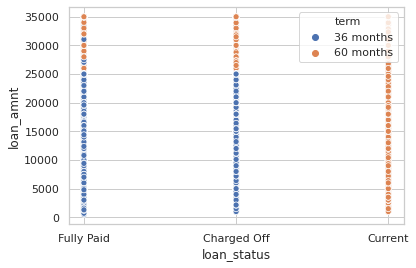

In [76]:
sns.scatterplot(x="loan_status", y="loan_amnt", hue="term",data=df);

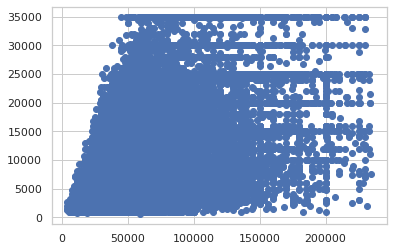

In [77]:
plt.scatter(x=df.annual_inc, y=df.loan_amnt)